In [103]:
from warnings import filterwarnings
filterwarnings(action="ignore")
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob as glb

from fastai.vision.all import *

import matplotlib.pyplot as plt

In [58]:
path_id = "/kaggle/input/sports-image-classification/dataset/train"
image_id = pd.read_csv("/kaggle/input/sports-image-classification/dataset/train.csv")

print(image_id.shape)

(8227, 2)


In [59]:
image_id.head()

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket


In [61]:
dataloader = ImageDataLoaders.from_df(df=image_id,
                                     folder=path_id,
                                     fn_col=0,
                                     label_col=1, 
                                     item_tfms=Resize(224))

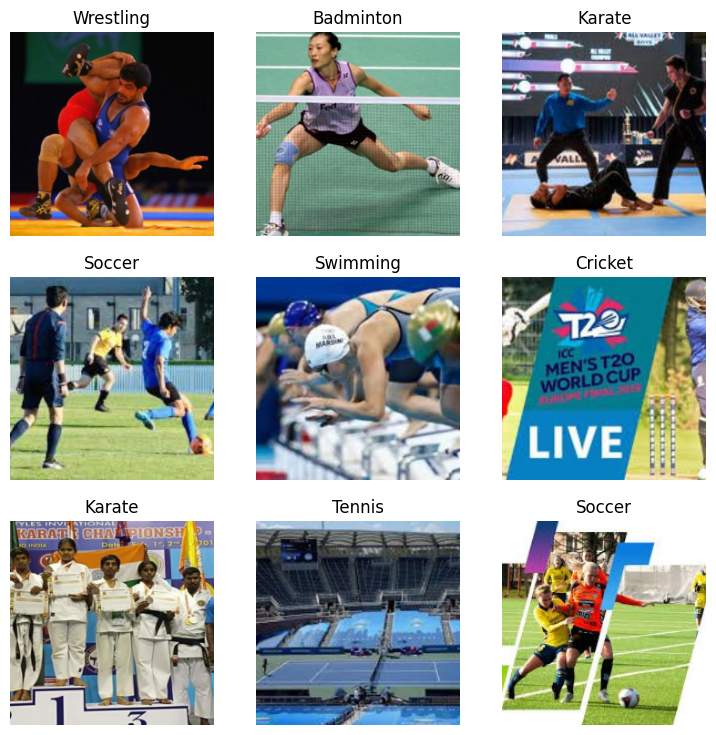

In [63]:
dataloader.train.show_batch()

In [64]:
learner = vision_learner(dls=dataloader,
                         arch=resnet50, 
                         metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.9MB/s]


SuggestedLRs(valley=0.001737800776027143)

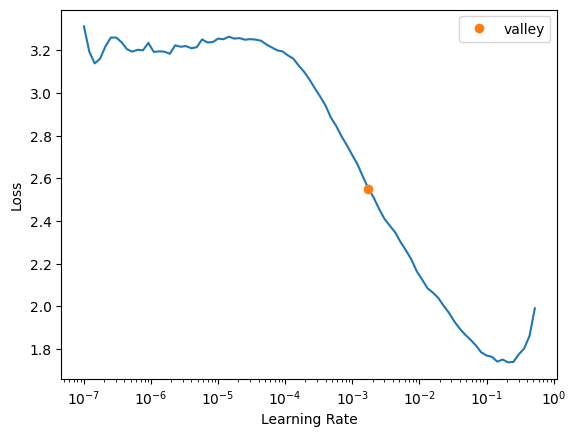

In [65]:
learner.lr_find()

In [66]:
learner.fine_tune(epochs=20, base_lr=0.001737800776027143)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.750658,0.308257,0.905775,0.094225,00:39


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.277859,0.189715,0.942857,0.057143,00:43
1,0.180282,0.152855,0.951976,0.048024,00:42
2,0.121812,0.136024,0.954407,0.045593,00:42
3,0.093950,0.144392,0.958055,0.041945,00:43
4,0.067304,0.142644,0.957447,0.042553,00:43
5,0.064905,0.144596,0.958055,0.041945,00:43
6,0.051512,0.121360,0.965350,0.034650,00:43
7,0.030174,0.121707,0.964742,0.035258,00:43
8,0.025621,0.117546,0.967173,0.032827,00:43
9,0.025881,0.106878,0.970213,0.029787,00:44


In [67]:
learner.export("learner_1.pkl")

In [68]:
interpreter = ClassificationInterpretation.from_learner(learner)

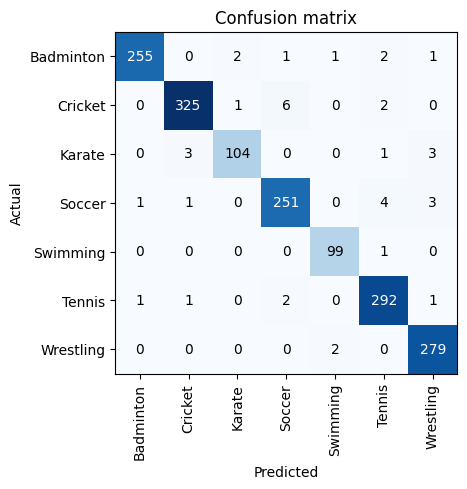

In [70]:
interpreter.plot_confusion_matrix()

In [71]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

   Badminton       0.99      0.97      0.98       262
     Cricket       0.98      0.97      0.98       334
      Karate       0.97      0.94      0.95       111
      Soccer       0.97      0.97      0.97       260
    Swimming       0.97      0.99      0.98       100
      Tennis       0.97      0.98      0.97       297
   Wrestling       0.97      0.99      0.98       281

    accuracy                           0.98      1645
   macro avg       0.97      0.97      0.97      1645
weighted avg       0.98      0.98      0.98      1645



In [73]:
dataloader_ = ImageDataLoaders.from_df(df=image_id,
                                       folder=path_id,
                                       fn_col=0,
                                       label_col=1, 
                                       item_tfms=Resize(224),
                                       batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()])

In [74]:
learner_ = vision_learner(dls=dataloader_,
                         arch=resnet101, 
                         metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:10<00:00, 17.6MB/s]   


SuggestedLRs(valley=0.0008317637839354575)

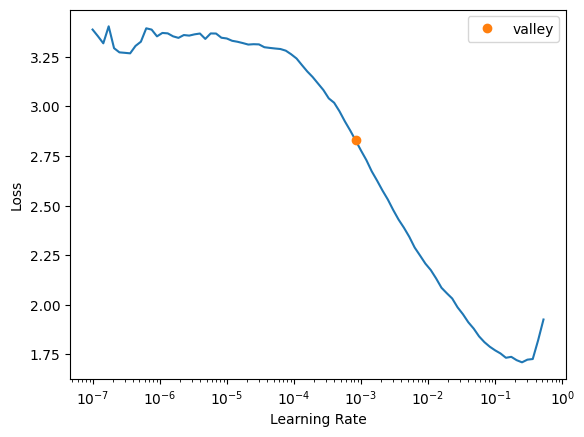

In [75]:
learner_.lr_find()

In [76]:
learner_.fine_tune(epochs=20, base_lr=0.0008317637839354575)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.924857,0.346144,0.886322,0.113678,00:49


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.360451,0.247403,0.918541,0.081459,01:03
1,0.278245,0.191260,0.937386,0.062614,01:03
2,0.208650,0.153972,0.950760,0.049240,01:03
3,0.136581,0.143361,0.955623,0.044377,01:03
4,0.091356,0.127359,0.963526,0.036474,01:03
5,0.068479,0.105104,0.969605,0.030395,01:03
6,0.046080,0.099099,0.970821,0.029179,01:03
7,0.043827,0.103636,0.969605,0.030395,01:03
8,0.026480,0.107408,0.970213,0.029787,01:03
9,0.026108,0.087625,0.975684,0.024316,01:04


In [77]:
learner.export("learner_2.pkl")

In [78]:
interpreter = ClassificationInterpretation.from_learner(learner_)

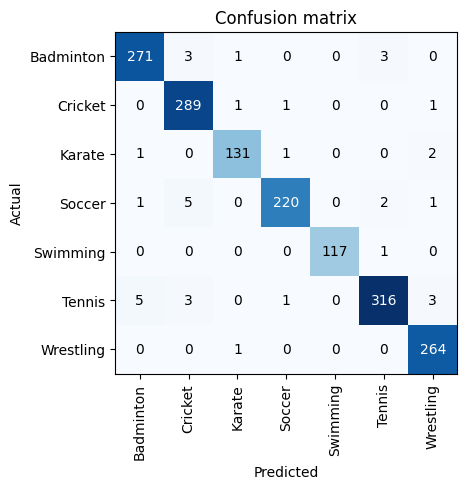

In [79]:
interpreter.plot_confusion_matrix()

In [80]:
interpreter.print_classification_report()

              precision    recall  f1-score   support

   Badminton       0.97      0.97      0.97       278
     Cricket       0.96      0.99      0.98       292
      Karate       0.98      0.97      0.97       135
      Soccer       0.99      0.96      0.97       229
    Swimming       1.00      0.99      1.00       118
      Tennis       0.98      0.96      0.97       328
   Wrestling       0.97      1.00      0.99       265

    accuracy                           0.98      1645
   macro avg       0.98      0.98      0.98      1645
weighted avg       0.98      0.98      0.98      1645



In [81]:
learn = load_learner("/kaggle/working/learner_2.pkl")

In [83]:
test_df = pd.read_csv("/kaggle/input/sports-image-classification/dataset/test.csv")

test_df.head()

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg


In [87]:
test_path = Path("/kaggle/input/sports-image-classification/dataset/test")

In [88]:
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [129]:
predictions, _ = learn.get_preds(dl=test_dl)

In [158]:
pth = "/kaggle/input/sports-image-classification/dataset/test"
test_img_path = [os.path.join(pth, i) for i in os.listdir(pth)[:9]]
preds = [learn.dls.vocab[i] for i in np.argmax(predictions, axis=1)][:9]

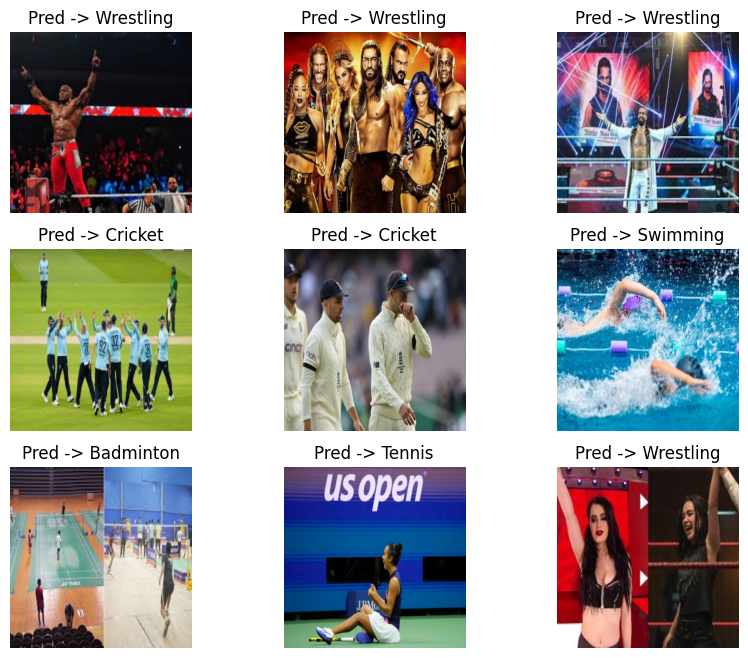

In [164]:
plt.figure(figsize=(10, 8))
for idx, (img_path, pred) in enumerate(zip(test_img_path, preds), start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (500, 500)))
    plt.title(f"Pred -> {pred}")
    plt.axis("off")
    
plt.show()

## Eddy